In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

from datashader.bundling import hammer_bundle  # key for bundling
from scipy.stats import gaussian_kde  # key for coloring hot bundles

import datetime as dt
import itertools as it
import geopandas as gpd 

plt.rc('axes', axisbelow=True)

%matplotlib inline

/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
# this file is here https://www.dropbox.com/s/4sjc802uazdz67h/example_flows.csv?dl=0
# it's arizona commute networks from census data
el_df = pd.read_csv('../data/example_flows.csv',dtype={'source':str,'target':str})

counties = list(set(el_df['source'].tolist() + el_df['target'].tolist()))
wel = [tuple(x) for x in el_df.to_numpy()]

G = nx.DiGraph()
G.add_weighted_edges_from(wel)
nodes = list(G.nodes())

G = nx.to_undirected(G)

In [3]:
# this file is here https://www.dropbox.com/sh/7yvz6fdxh9eof01/AAA5hWtA7dmVhqL4YxifHkvGa?dl=0
county_shp = gpd.read_file('../data/tl_2017_us_county/')

county_shp = county_shp.loc[~(county_shp['STATEFP'].isin(['78','60','72','66','02','15','69']))]
az_shp = county_shp.loc[county_shp['GEOID'].isin(counties)]

az_shp.crs = {"init": "epsg:4326"}
az_shp = az_shp.to_crs(epsg=3395)

az_pos = az_shp[['GEOID','INTPTLAT','INTPTLON']].reset_index()
pos = dict(zip(az_pos['GEOID'],list(zip(az_shp.geometry.centroid.x.tolist(),
                                        az_shp.geometry.centroid.y.tolist()))))

county_shp.crs = {"init": "epsg:4326"}
county_shp = county_shp.to_crs(epsg=3395)

In [4]:
nodes_py = [[name, a[0], a[1]] for name, a in pos.items()]
ds_nodes = pd.DataFrame(nodes_py, columns=['name', 'x', 'y'])
ds_nodes['name'] = ds_nodes['name'].astype(str)
ds_nodes = ds_nodes.sort_values('name')
ds_nodes['num'] = list(range(ds_nodes.shape[0]))

ds_edges_py = [[n0, n1] for (n0, n1) in G.edges]
ds_edges = pd.DataFrame(ds_edges_py, columns=['source', 'target']).astype(str)

mapping = ds_nodes[['name','num']]
mapping_dict = dict(zip(ds_nodes['name'],ds_nodes['num']))

ds_edges['source_num'] = [mapping_dict[i] for i in ds_edges['source']]
ds_edges['target_num'] = [mapping_dict[i] for i in ds_edges['target']]

ds_e = ds_edges[['source_num','target_num']]
ds_e.columns = ['source','target']
ds_n = ds_nodes[['num','x','y']]
ds_n.columns = ['name','x','y']

In [5]:
hbs = []
max_seg_lengths = [0.005,0.004,0.006,0.016]
min_seg_lengths = [0.002,0.001,0.003,0.008]
decays = [0.25, 0.5, 0.90, 0.70]
ibs    = [0.20, 2.0, 0.75, 0.05]

for i in range(len(ibs)):
    ma_sl = max_seg_lengths[i]
    mi_sl = min_seg_lengths[i]
    di = decays[i]
    ibi = ibs[i]
    hb_i = hammer_bundle(ds_n, ds_e,
                         max_segment_length=ma_sl,
                         min_segment_length=mi_sl,
                         decay=di,
                         initial_bandwidth=ibi)
    hbs.append(hb_i)
    print(i, hb_i.shape)

0 (35033, 2)
1 (47959, 2)
2 (22930, 2)
3 (9897, 2)


In [6]:
# ^ useful param values

#############################################################
# Name                  Value      Type      Bounds      Mode  
#############################################################
# accuracy               500     Integer   (1, None)     V RW  
# advect_iterations       50     Integer   (0, None)     V RW  
# batch_size            20000    Integer   (1, None)     V RW  
# decay                  0.7      Number   (0.0, 1.0)    V RW  
# include_edge_id       False    Boolean     (0, 1)      V RW  
# initial_bandwidth      0.05     Number  (0.0, None)    V RW  
# iterations              4      Integer   (1, None)     V RW  
# max_segment_length    0.016     Number   (0, None)     V RW  
# min_segment_length    0.008     Number   (0, None)     V RW  
# source               'source'   String                 V RW  
# target               'target'   String                 V RW  
# tension                0.3      Number   (0, None)     V RW  
# weight               'weight'   String               V RW AN 
# x                      'x'      String                 V RW  
# y                      'y'      String                 V RW  
#############################################################

0
1
2
3


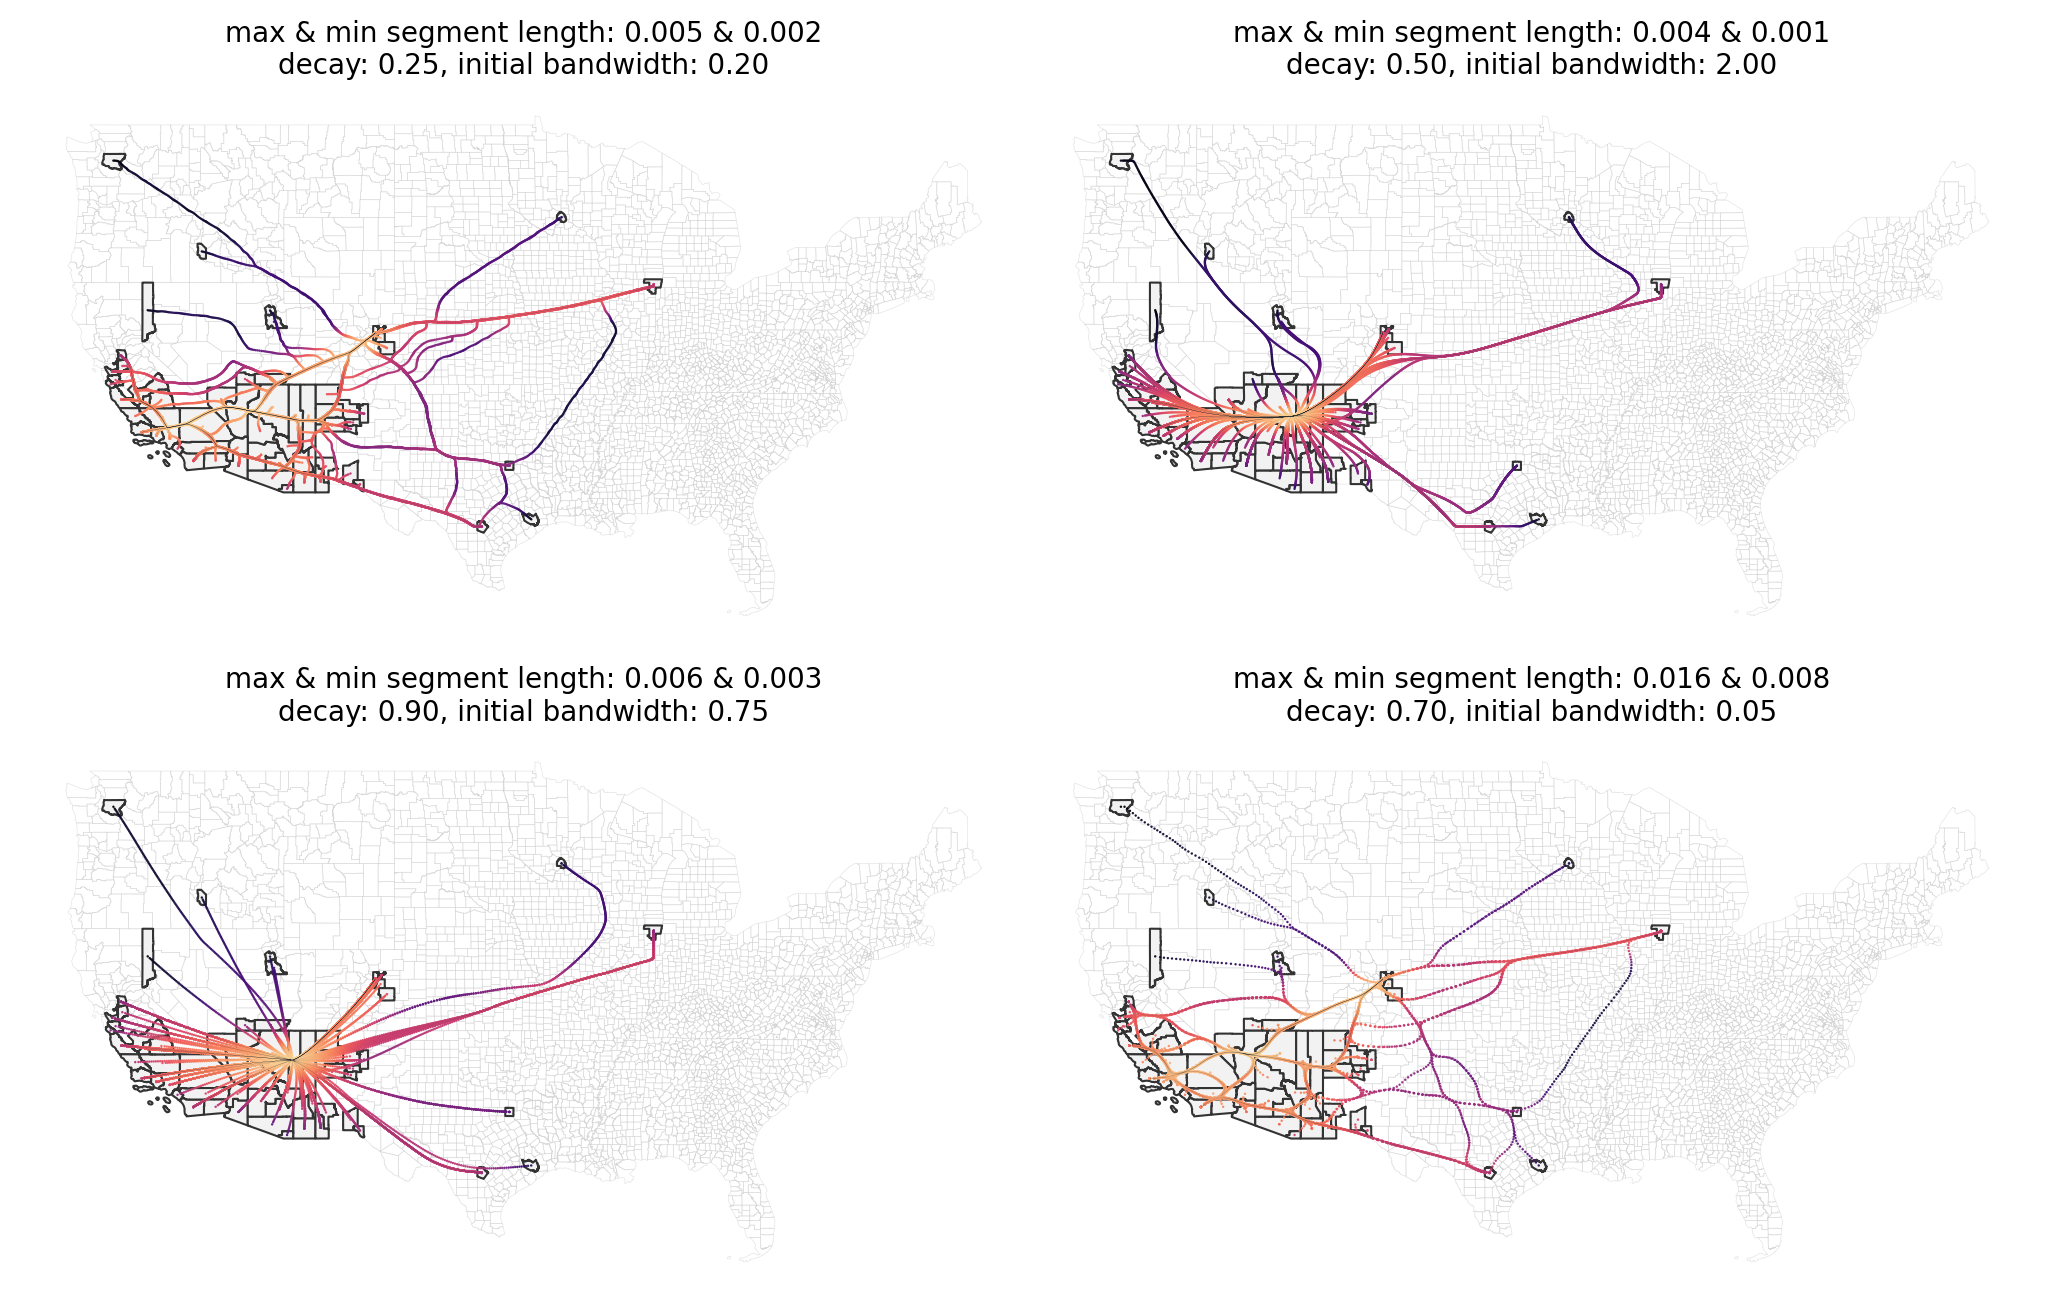

In [7]:
ncols = 2
nrows = 2
tups = list(it.product(range(nrows), range(ncols)))

fig, ax = plt.subplots(ncols,nrows,figsize=(ncols*6.5,nrows*4.0),dpi=200)
plt.subplots_adjust(hspace=0.15,wspace=0.0)

for i,a in enumerate(tups):
    print(i)
    hb = hbs[i]

    yvals = hb.dropna()['y']
    xvals = hb.dropna()['x']
    xy = np.vstack([xvals, yvals])
    z = gaussian_kde(xy)(xy)
    zcol = np.log(z)-min(np.log(z))

    az_shp.plot(ax=ax[a], ec='.2', fc='.95', lw=0.75)

    ax[a].plot(hb['x'],hb['y'],linewidth=0.005,color='.2')
    ax[a].scatter(xvals, yvals, s=0.75, lw=0, c=zcol, cmap='magma', vmax=zcol.max()*1.1, alpha=0.95)
    # ax[a].scatter(xvals, yvals, s=1, lw=0, c=z, cmap='magma',vmax=z.max()*1.1)

    ras = county_shp.plot(ax=ax[a], ec='.8', fc='None', lw=0.25, alpha=0.5, zorder=0)
    ras.set_rasterized(True)

    ax[a].set_axis_off()

    ma_sl = max_seg_lengths[i]
    mi_sl = min_seg_lengths[i]
    di = decays[i]
    ibi = ibs[i]
    ax[a].set_title('max & min segment length: %.3f & %.3f\ndecay: %.2f, initial bandwidth: %.2f'%(
                     ma_sl,mi_sl,di,ibi),fontsize='medium')
    
plt.savefig('../figs/pngs/edge_bundling_test.png', dpi=600, bbox_inches='tight')
# plt.savefig('../figs/pdfs/edge_bundling_test.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [8]:
# https://datashader.org/user_guide/Networks.html

In [14]:
import datetime as dt
hbs = []
decays = np.linspace(0.05,0.95,6).round(2)
ibs    = np.logspace(-1, 0, 6).round(4)
ma_sl = 0.006
mi_sl = 0.003

xi = 0
for ibi in ibs:
    for di in decays:
        hb_i = hammer_bundle(ds_n, ds_e,
                         max_segment_length=ma_sl,
                         min_segment_length=mi_sl,
                         decay=di,
                         initial_bandwidth=ibi)
        hbs.append(hb_i)
        xi += 1
        print("%02i"%xi, hb_i.shape, dt.datetime.now())

01 (14573, 2) 2020-05-25 10:28:48.212162
02 (25569, 2) 2020-05-25 10:28:48.525074
03 (26871, 2) 2020-05-25 10:28:49.013298
04 (26753, 2) 2020-05-25 10:28:49.687664
05 (24925, 2) 2020-05-25 10:28:50.409832
06 (23438, 2) 2020-05-25 10:28:51.110860
07 (14573, 2) 2020-05-25 10:28:51.148401
08 (24336, 2) 2020-05-25 10:28:51.301813
09 (27872, 2) 2020-05-25 10:28:51.785597
10 (27896, 2) 2020-05-25 10:28:52.430161
11 (25682, 2) 2020-05-25 10:28:53.120685
12 (23321, 2) 2020-05-25 10:28:54.094468
13 (25642, 2) 2020-05-25 10:28:54.394856
14 (27718, 2) 2020-05-25 10:28:54.805631
15 (28647, 2) 2020-05-25 10:28:55.312357
16 (28045, 2) 2020-05-25 10:28:55.932073
17 (25512, 2) 2020-05-25 10:28:56.544380
18 (23491, 2) 2020-05-25 10:28:57.297021
19 (24217, 2) 2020-05-25 10:28:57.457170
20 (27508, 2) 2020-05-25 10:28:57.746204
21 (30316, 2) 2020-05-25 10:28:58.388502
22 (28077, 2) 2020-05-25 10:28:59.038350
23 (24296, 2) 2020-05-25 10:28:59.797703
24 (24072, 2) 2020-05-25 10:29:00.787284
25 (22655, 2) 20

00 2020-05-25 10:29:18.783429
01 2020-05-25 10:29:26.618575
02 2020-05-25 10:29:41.756985
03 2020-05-25 10:30:01.302984
04 2020-05-25 10:30:36.695257
05 2020-05-25 10:31:03.251885
06 2020-05-25 10:31:32.810541
07 2020-05-25 10:32:02.471290
08 2020-05-25 10:32:39.715769
09 2020-05-25 10:33:22.914919
10 2020-05-25 10:34:10.262833
11 2020-05-25 10:34:59.690438
12 2020-05-25 10:35:51.872997
13 2020-05-25 10:36:49.257782
14 2020-05-25 10:37:51.148707
15 2020-05-25 10:38:57.875185
16 2020-05-25 10:40:07.998360
17 2020-05-25 10:41:20.731251
18 2020-05-25 10:42:35.969321
19 2020-05-25 10:43:56.195039
20 2020-05-25 10:45:23.222344
21 2020-05-25 10:47:04.707524
22 2020-05-25 10:48:45.620547
23 2020-05-25 10:50:28.959144
24 2020-05-25 10:52:13.853829
25 2020-05-25 10:54:06.418991
26 2020-05-25 10:56:05.898187
27 2020-05-25 10:58:08.709735
28 2020-05-25 11:00:10.113401
29 2020-05-25 11:02:23.114987
30 2020-05-25 11:04:39.856809
31 2020-05-25 11:06:59.830287
32 2020-05-25 11:09:27.912644
33 2020-05

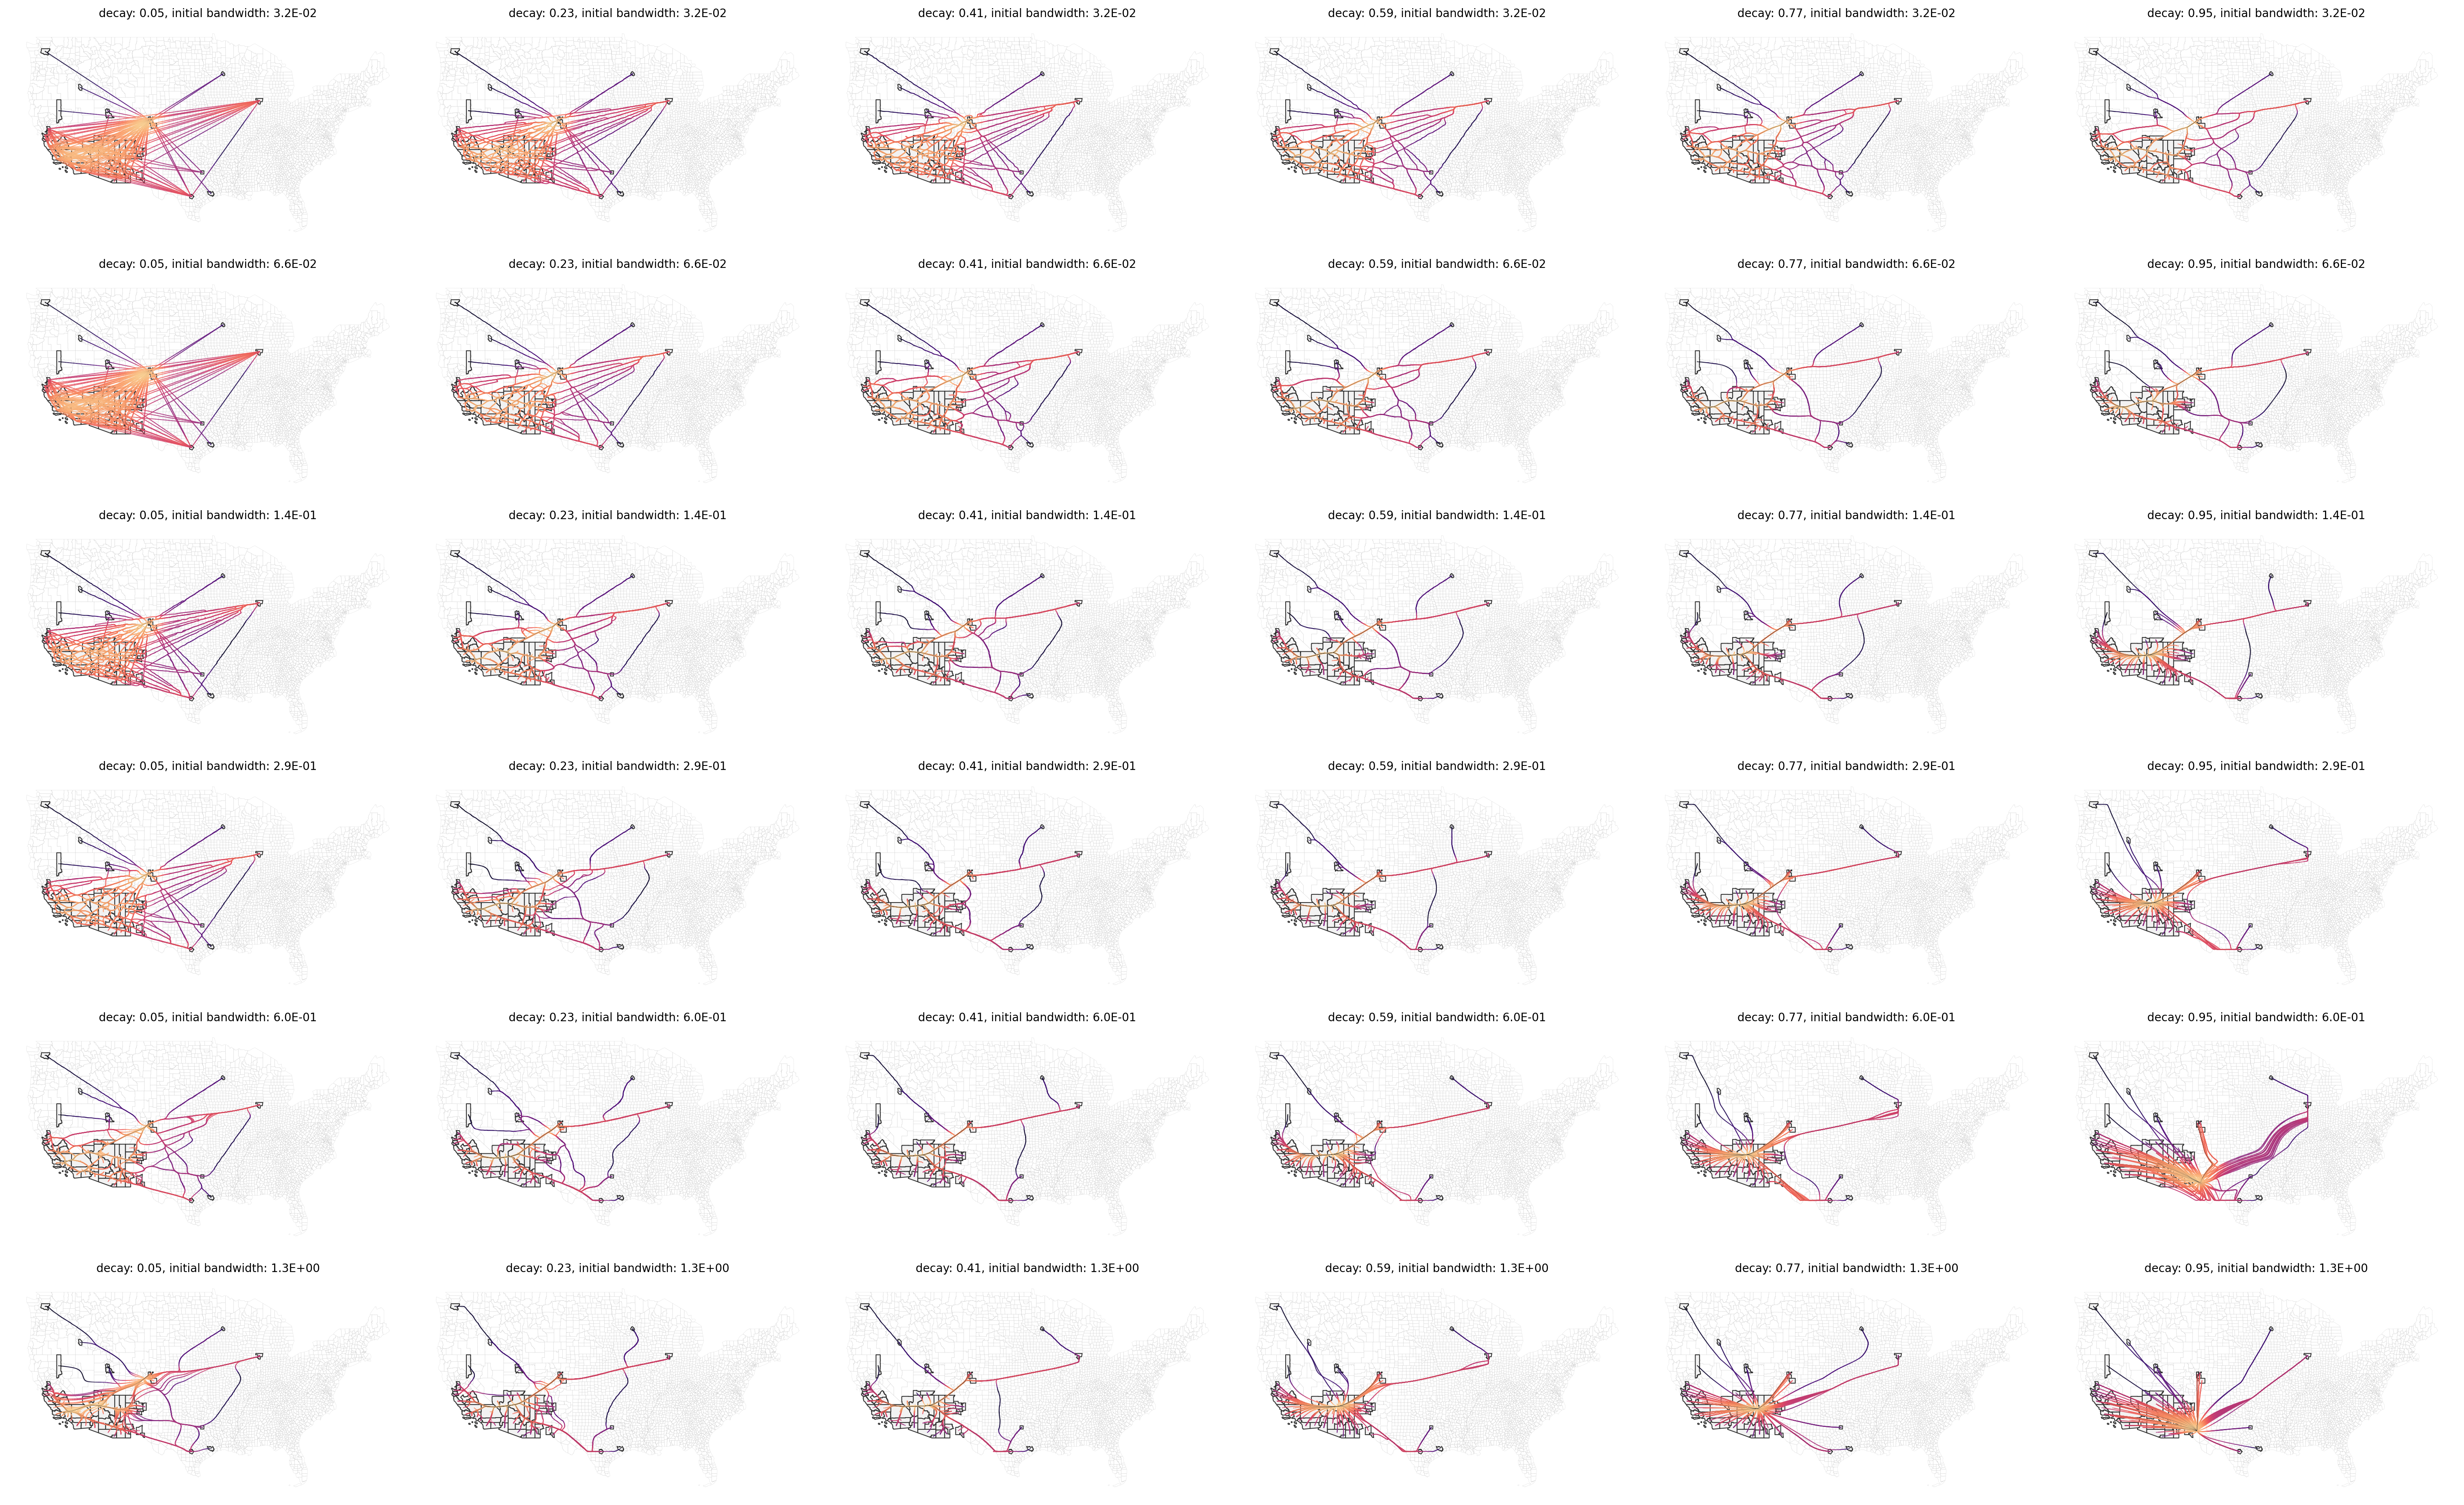

In [15]:
ncols = len(decays)
nrows = len(ibs)
tups = list(it.product(range(nrows), range(ncols)))

fig, ax = plt.subplots(ncols,nrows,figsize=(ncols*6.5,nrows*4.0),dpi=200)
plt.subplots_adjust(hspace=0.15,wspace=0.0)

for i,a in enumerate(tups):
    print("%02i"%i, dt.datetime.now())        
    hb = hbs[i]

    yvals = hb.dropna()['y']
    xvals = hb.dropna()['x']
    xy = np.vstack([xvals, yvals])
    z = gaussian_kde(xy)(xy)
    zcol = np.log(z)-min(np.log(z))

    az_shp.plot(ax=ax[a], ec='.2', fc='.95', lw=0.75)

    ax[a].plot(hb['x'],hb['y'],linewidth=0.005,color='.2')
    ax[a].scatter(xvals, yvals, s=0.75, lw=0, c=zcol, cmap='magma', vmax=zcol.max()*1.1, alpha=0.95)
    # ax[a].scatter(xvals, yvals, s=1, lw=0, c=z, cmap='magma',vmax=z.max()*1.1)

    ras = county_shp.plot(ax=ax[a], ec='.8', fc='None', lw=0.25, alpha=0.5, zorder=0)
    ras.set_rasterized(True)

    ax[a].set_axis_off()

    di = decays[a[1]]
    ibi = ibs[a[0]]
    ax[a].set_title('decay: %.2f, initial bandwidth: %.1E'%(di,ibi),fontsize='medium')
    
plt.savefig('../figs/pngs/edge_bundling_test_many.png', dpi=600, bbox_inches='tight')
# plt.savefig('../figs/pdfs/edge_bundling_test.pdf', dpi=300, bbox_inches='tight')

plt.show()